In [1]:
import sqlite3
import pandas
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import prophet

pandas.options.mode.copy_on_write = True

conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select sum(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration, data_time.date, attendances * 10000 / commune.population from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'concentration', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])

# scale
scaler = StandardScaler()
data[['concentration']] = scaler.fit_transform(data[['concentration']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

,commune,concentration,date,attendances
date,,,,
2018-01-01,LA CISTERNA,0.318082,2018-01-01,0.301024
2018-01-01,PENALOLEN,-1.227433,2018-01-01,0.614815
2018-01-01,PUENTE ALTO,0.839011,2018-01-01,0.824010
2018-01-01,TALAGANTE,-1.602993,2018-01-01,-0.849545
2018-02-01,LA CISTERNA,-1.384115,2018-02-01,-0.640351
...,...,...,...,...
2024-04-01,LA CISTERNA,1.280945,2024-04-01,1.137801
2024-04-01,PENALOLEN,0.998143,2024-04-01,0.510218
2024-05-01,PENALOLEN,1.432024,2024-05-01,0.614815


23:32:22 - cmdstanpy - INFO - Chain [1] start processing
23:32:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE for LA CISTERNA: 1.0512101053122314


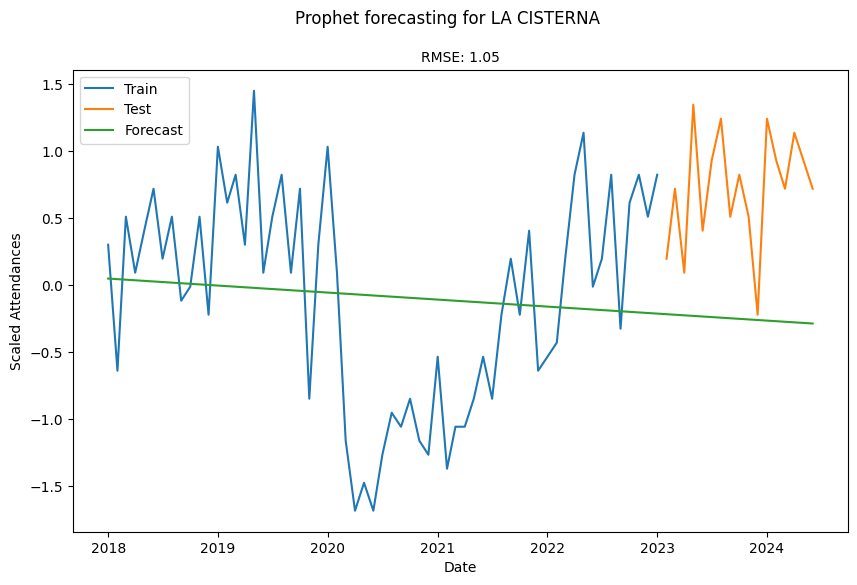

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for LA CISTERNA with SO2: 0.6054960759207503


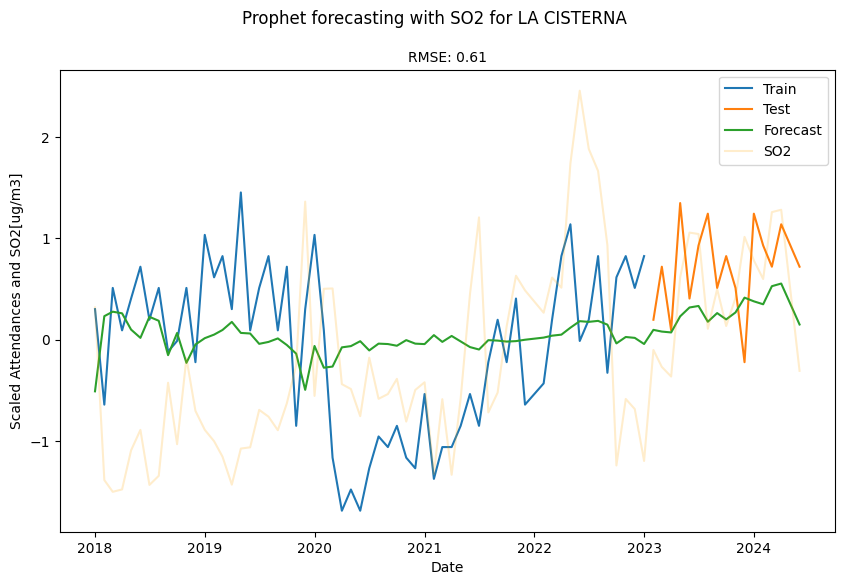

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for PENALOLEN: 1.2112107896364512


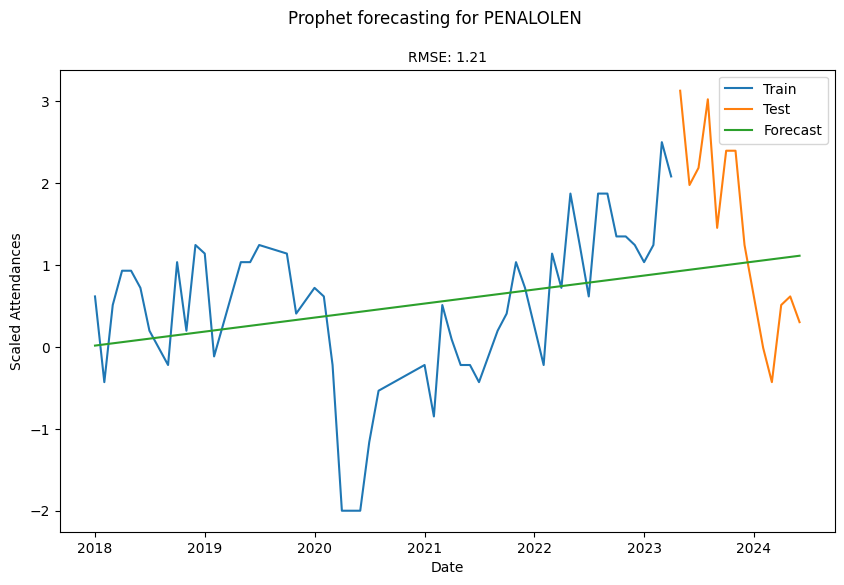

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for PENALOLEN with SO2: 1.4115975371604799


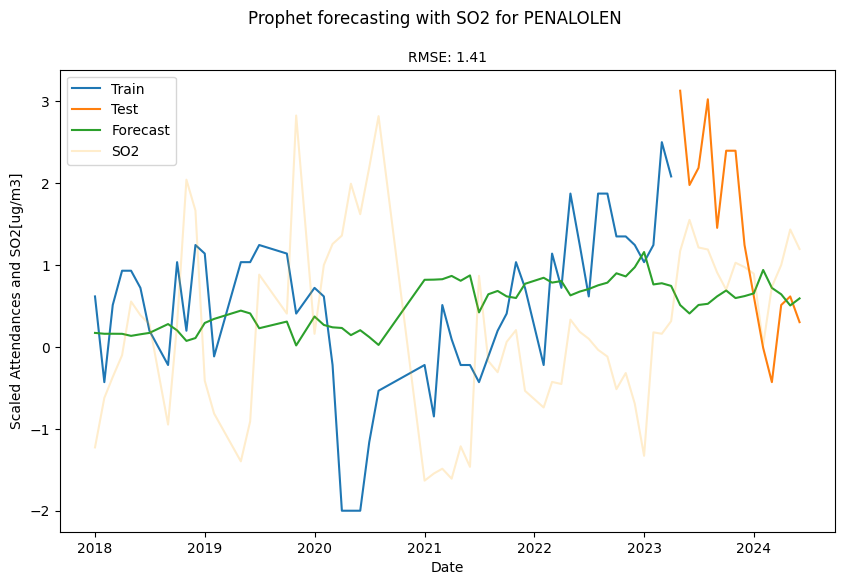

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for PUENTE ALTO: 0.8110428362159927


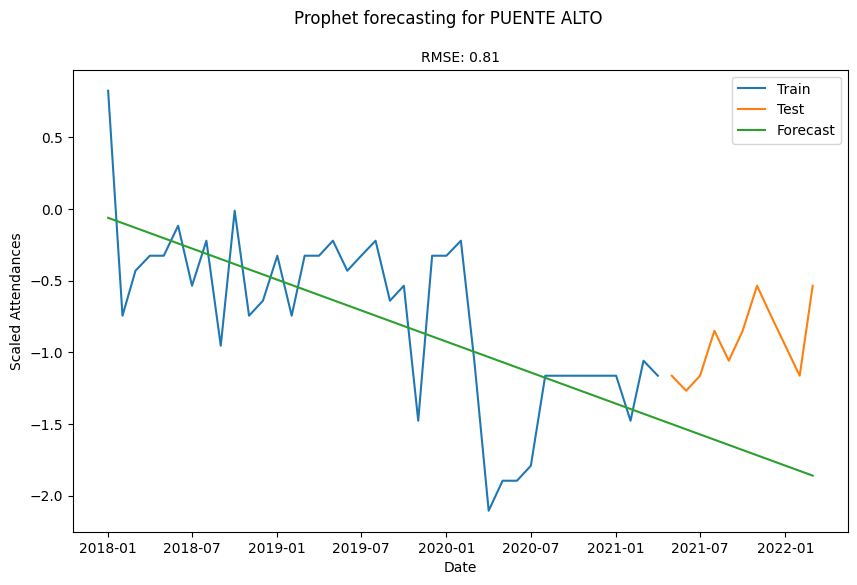

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for PUENTE ALTO with SO2: 0.6259823592782398


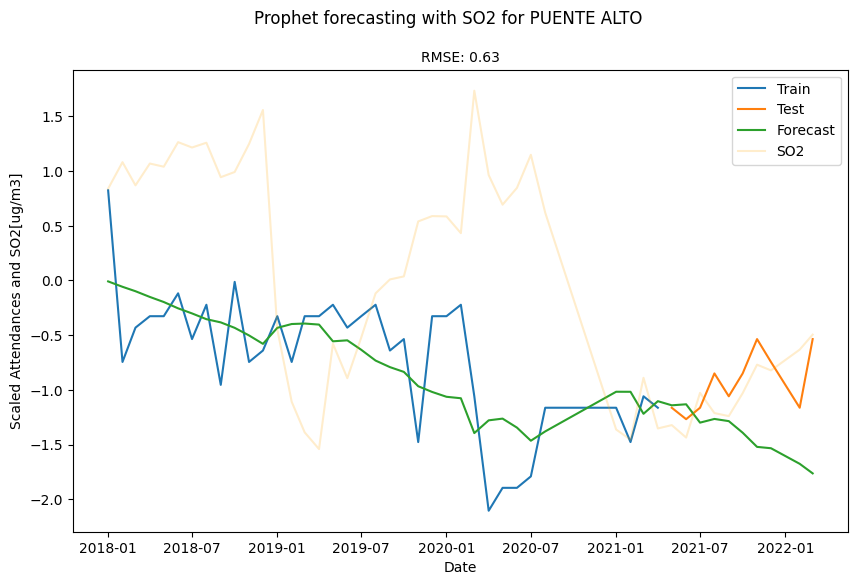

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for TALAGANTE: 0.9869728482979649


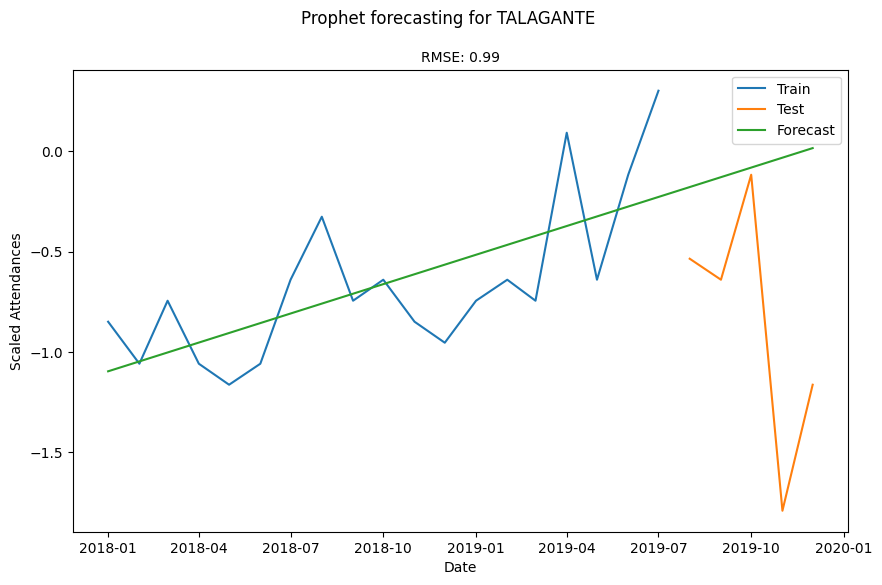

23:32:23 - cmdstanpy - INFO - Chain [1] start processing
23:32:23 - cmdstanpy - INFO - Chain [1] done processing


RMSE for TALAGANTE with SO2: 1.0707875958114712


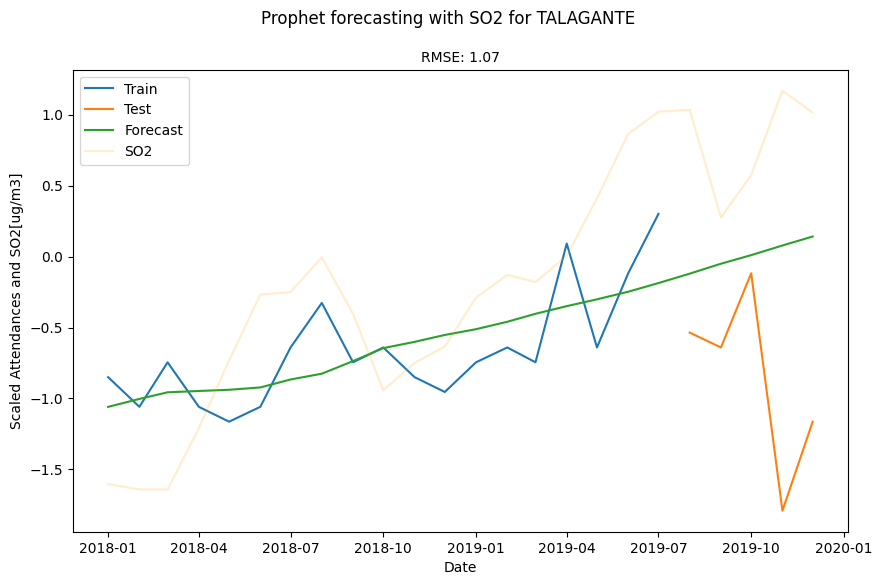

In [2]:
for commune in data['commune'].unique():
    A = data[data['commune'] == commune]
    A.rename(columns={'date': 'ds', 'attendances': 'y'}, inplace=True)
    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    m = prophet.Prophet(yearly_seasonality=False)
    m.fit(A_train)

    forecast = m.predict(A)

    # get rmse
    rmse = root_mean_squared_error(A_test['y'], forecast['yhat'][-len(A_test):])
    print(f'RMSE for {commune}: {rmse}')

    # plot train and test
    plt.figure(figsize=(10,6))
    plt.xlabel('Date')
    plt.ylabel('Scaled Attendances')
    plt.suptitle('Prophet forecasting for ' + commune)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.plot(A_train.index, A_train['y'], label='Train')
    plt.plot(A_test.index, A_test['y'], label='Test')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.legend()
    plt.savefig(f'img/prophet_{commune}.png')
    plt.show()

    # with extra regressor
    m = prophet.Prophet(yearly_seasonality=False)
    m.add_regressor('concentration', mode='multiplicative')
    m.fit(A_train)

    forecast = m.predict(A)

    # get rmse
    rmse = root_mean_squared_error(A_test['y'], forecast['yhat'][-len(A_test):])
    print(f'RMSE for {commune} with SO2: {rmse}')

    # plot train and test
    plt.figure(figsize=(10,6))
    plt.xlabel('Date')
    plt.ylabel('Scaled Attendances and SO2[ug/m3]')
    plt.suptitle('Prophet forecasting with SO2 for ' + commune)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.plot(A_train.index, A_train['y'], label='Train')
    plt.plot(A_test.index, A_test['y'], label='Test')
    # plot only test forecast
    # plt.plot(forecast['ds'][-len(A_test):], forecast['yhat'][-len(A_test):], label='Forecast')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.plot(A.index, A['concentration'], label='SO2', color='orange', alpha=0.2)
    plt.legend()
    plt.savefig(f'img/prophet_{commune}_so2.png')
    plt.show()

